In [8]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from simulations.analysis.collect_bb_simulation_data import aggregate_data

ascending_confidences = {
    "pred_llr": False,
    "detector_density": False,
    "cluster_size_norm": False,
    "cluster_size_norm_gap": True,
    "cluster_llr_norm": False,
    "cluster_llr_norm_gap": True,
}

orders = [0.5, 1, 2, 3, np.inf]

df_agg_dict = {}
for by, ascending_confidence in ascending_confidences.items():
    print(
        f"\nAggregating data for {by} with ascending_confidence={ascending_confidence}..."
    )
    if "norm" in by:
        for order in orders:
            print(f"norm_order = {order}")
            df_agg = aggregate_data(
                by,
                n=144,
                p=0.001,
                norm_order=order,
                num_hist_bins=10000,
                ascending_confidence=ascending_confidence,
                data_dir="../data/bb_minsum_iter30_lsd0",
                verbose=False,
            )
            df_agg_dict[by + f"_{order}"] = (df_agg, ascending_confidence)
    else:
        df_agg = aggregate_data(
            by=by,
            n=144,
            p=0.001,
            num_hist_bins=10000,
            ascending_confidence=ascending_confidence,
            data_dir="../data/bb_minsum_iter30_lsd0",
            verbose=False,
        )
        df_agg_dict[by] = (df_agg, ascending_confidence)

    print("=============")


Aggregating data for pred_llr with ascending_confidence=False...


Range detection:   0%|          | 0/1 [00:00<?, ?it/s]

Aggregation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Aggregating data for detector_density with ascending_confidence=False...


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Aggregating data for cluster_size_norm with ascending_confidence=False...
norm_order = 0.5


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


norm_order = 1


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


norm_order = 2


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


norm_order = 3


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


norm_order = inf


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]



Aggregating data for cluster_size_norm_gap with ascending_confidence=True...
norm_order = 0.5


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


norm_order = 1


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


norm_order = 2


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


norm_order = 3


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


norm_order = inf


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]



Aggregating data for cluster_llr_norm with ascending_confidence=False...
norm_order = 0.5


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


norm_order = 1


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


norm_order = 2


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


norm_order = 3


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


norm_order = inf


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]



Aggregating data for cluster_llr_norm_gap with ascending_confidence=True...
norm_order = 0.5


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


norm_order = 1


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


norm_order = 2


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


norm_order = 3


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


norm_order = inf


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

In [10]:
from simulation_data_utils import get_df_ps

df_ps_dict = {}
for by, (df_agg, ascending_confidence) in df_agg_dict.items():
    df_ps = get_df_ps(df_agg, ascending_confidence=ascending_confidence)
    df_ps_dict[by] = df_ps

In [14]:
def error_band_plot(
    x, y, delta_y, ax=None, color=None, alpha=0.3, **kwargs
):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, y, color=color, **kwargs)
    ax.fill_between(
        x,
        y - delta_y,
        y + delta_y,
        alpha=alpha,
        color=color,
    )

In [17]:
data = pd.read_feather('../data/bb_minsum_iter30_lsd0/n144_T12_p0.001/batch_1/scalars.feather')

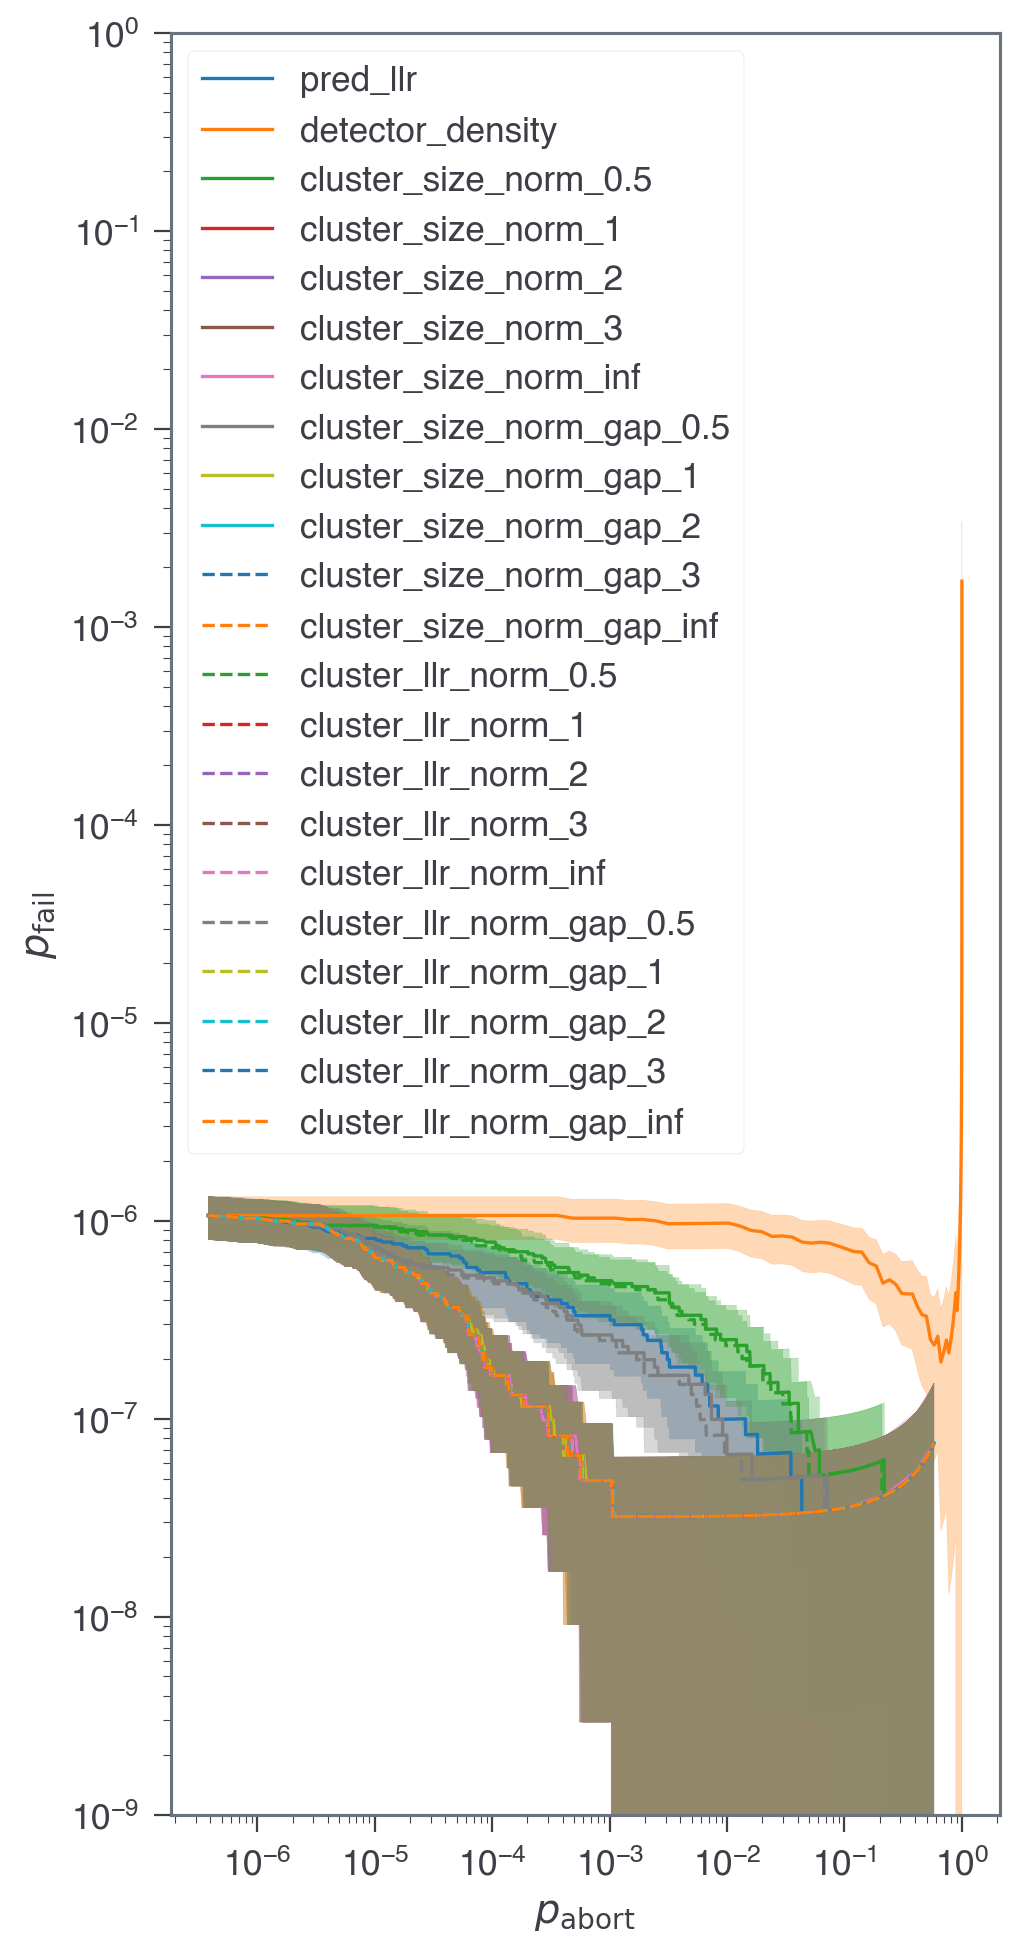

In [15]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 10))

T = 12

i = 0
data_plots = {}
for by, df_ps in df_ps_dict.items():
    use_conv = by != "detector_density"
    p_abort_col = "p_abort_conv" if use_conv else "p_abort"
    p_fail_col = "p_fail_conv" if use_conv else "p_fail"
    delta_p_fail_col = "delta_p_fail_conv" if use_conv else "delta_p_fail"

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values / T
    delta_p_fail = df_ps[delta_p_fail_col].values / T
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=COLORS(i % 10),
        linestyle="-" if i < 10 else "--",
        label=by,
        ax=ax,
    )
    i += 1

ax.set_xscale("log")
# ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-9, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{fail}$")

fig.tight_layout()

0: cluster_size_norm_3 (1.65e-07 ± 9.78e-08)
1: cluster_size_norm_inf (1.65e-07 ± 9.78e-08)
2: cluster_size_norm_2 (1.65e-07 ± 9.78e-08)
3: cluster_size_norm_gap_3 (1.65e-07 ± 9.78e-08)
4: cluster_llr_norm_gap_2 (1.65e-07 ± 9.78e-08)
5: cluster_llr_norm_inf (1.65e-07 ± 9.78e-08)
6: cluster_llr_norm_3 (1.65e-07 ± 9.78e-08)
7: cluster_llr_norm_2 (1.65e-07 ± 9.78e-08)
8: cluster_size_norm_gap_inf (1.65e-07 ± 9.78e-08)
9: cluster_llr_norm_gap_3 (1.65e-07 ± 9.78e-08)
10: cluster_llr_norm_gap_inf (1.65e-07 ± 9.78e-08)
11: cluster_size_norm_gap_2 (1.65e-07 ± 9.78e-08)
12: cluster_size_norm_gap_1 (1.82e-07 ± 1.03e-07)
13: cluster_size_norm_1 (1.82e-07 ± 1.03e-07)
14: cluster_llr_norm_1 (1.82e-07 ± 1.03e-07)
15: cluster_llr_norm_gap_1 (1.82e-07 ± 1.03e-07)
16: cluster_llr_norm_gap_0.5 (4.99e-07 ± 1.76e-07)
17: cluster_size_norm_gap_0.5 (5.15e-07 ± 1.79e-07)
18: pred_llr (5.49e-07 ± 1.85e-07)
19: cluster_llr_norm_0.5 (7.32e-07 ± 2.14e-07)
20: cluster_size_norm_0.5 (7.82e-07 ± 2.21e-07)
21: detec

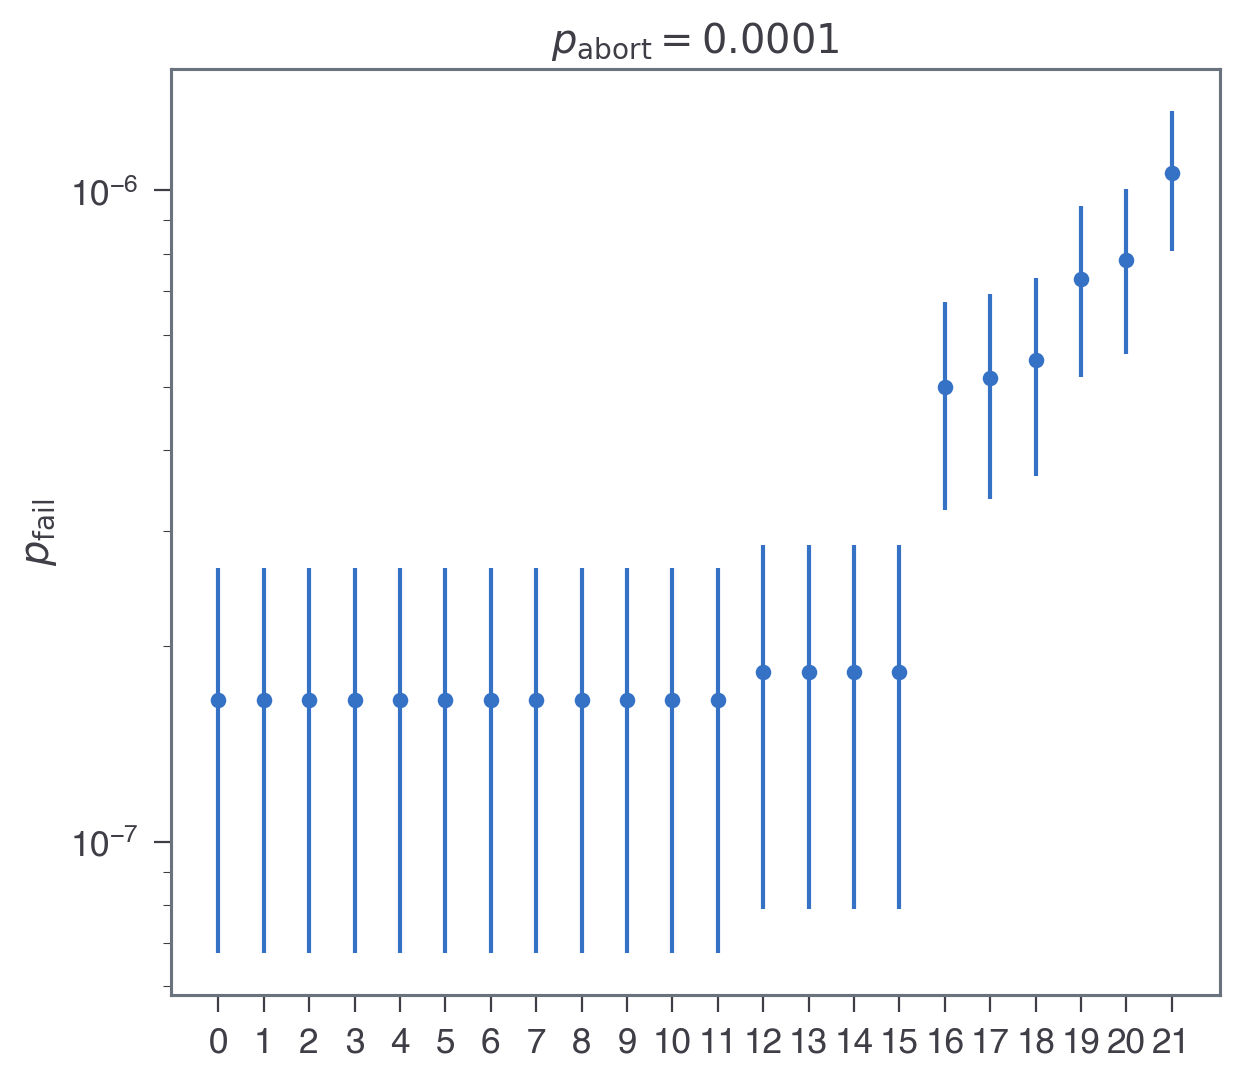

In [21]:
target = 1e-4
bys, y_vals, y_errs = [], [], []

for by, (p_abort, p_fail, delta_p_fail) in data_plots.items():
    idx = np.where(p_abort <= target)[0]
    if len(idx):
        sel = idx[-1]
    else:
        sel = 0
    bys.append(by)
    y_vals.append(p_fail[sel])
    y_errs.append(delta_p_fail[sel])

sort_inds = np.argsort(y_vals)
by_sorted = [bys[i] for i in sort_inds]
y_vals_sorted = [y_vals[i] for i in sort_inds]
y_errs_sorted = [y_errs[i] for i in sort_inds]

for i, by in enumerate(by_sorted):
    print(f"{i}: {by} ({y_vals_sorted[i]:.2e} ± {y_errs_sorted[i]:.2e})")

x_pos = np.arange(len(bys))

plt.errorbar(
    x_pos,
    y_vals_sorted,
    yerr=y_errs_sorted,
    fmt="o",
    capsize=5,
    lw=1.5,
    markeredgecolor="k",
)
plt.title(rf"$p_\mathrm{{abort}} = {target}$")
plt.xticks(x_pos, x_pos)
plt.ylabel(r"$p_{\mathrm{fail}}$")
plt.yscale("log")
plt.tight_layout()
plt.show()